In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
import string
import pickle   # for saving trained HMMs
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# === Load and preprocess corpus ===

def load_corpus(path: str):
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().splitlines()

    # Clean words: lowercase, alphabetic only
    words = []
    for w in raw:
        w = w.strip().lower()
        # remove non-alpha chars
        w = ''.join([ch for ch in w if ch.isalpha()])
        if len(w) > 0:
            words.append(w)

    return words

# Load your corpus
corpus_path = "/content/drive/MyDrive/ML_hackathon/Data/corpus.txt"
words = load_corpus(corpus_path)

print(f"✅ Loaded {len(words):,} words from corpus.")
print("Sample words:", words[:10])

✅ Loaded 50,000 words from corpus.
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']


,Word Length,Count
19,1,46
18,2,84
12,3,388
11,4,1169
9,5,2340
1,6,3755
13,7,5111
6,8,6369
2,9,6787
5,10,6465


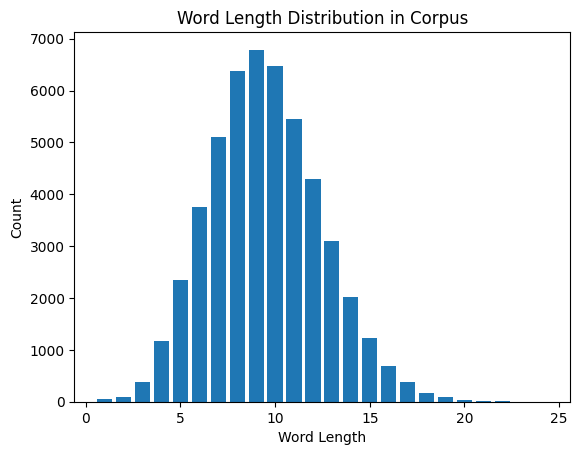

In [4]:
# Compute word length distribution
length_counts = Counter(len(w) for w in words)

df_lengths = pd.DataFrame(list(length_counts.items()), columns=["Word Length", "Count"]).sort_values("Word Length")
display(df_lengths)

# Optional: visualize if you want to see spread
try:
    import matplotlib.pyplot as plt
    plt.bar(df_lengths["Word Length"], df_lengths["Count"])
    plt.xlabel("Word Length")
    plt.ylabel("Count")
    plt.title("Word Length Distribution in Corpus")
    plt.show()
except ImportError:
    print("matplotlib not installed — skipping visualization.")


In [5]:
# === Step 4A: Prepare training sequences for each word length ===

def prepare_sequences_by_length(words):
    seqs_by_len = defaultdict(list)
    for w in words:
        L = len(w)
        seq = ['^'] + list(w) + ['$']  # add start & end tokens
        seqs_by_len[L].append(seq)
    return seqs_by_len

seqs_by_len = prepare_sequences_by_length(words)
print(f"Prepared sequences for {len(seqs_by_len)} different lengths.")
print(f"Example for length 5: {seqs_by_len[5][:5]}")


Prepared sequences for 24 different lengths.
Example for length 5: [['^', 'u', 'n', 'b', 'e', 'd', '$'], ['^', 'u', 'p', 'b', 'i', 'd', '$'], ['^', 'l', 'i', 'n', 'g', 'e', '$'], ['^', 'b', 'i', 'r', 'm', 'a', '$'], ['^', 'b', 'r', 'o', 'c', 'k', '$']]


In [6]:
# === Step 4B (Updated): Train length-specific + bucket HMMs ===

def train_char_HMM(sequences, smoothing=2.0):
    """Train a simple character bigram HMM with Laplace smoothing."""
    symbols = ['^'] + list(string.ascii_lowercase) + ['$']
    idx = {s: i for i, s in enumerate(symbols)}
    n = len(symbols)

    A_counts = np.zeros((n, n))
    pi_counts = np.zeros(n)

    for seq in sequences:
        if len(seq) < 2:
            continue
        # first real letter contributes to pi (after ^)
        pi_counts[idx[seq[1]]] += 1
        for a, b in zip(seq, seq[1:]):
            A_counts[idx[a], idx[b]] += 1

    # Laplace (add-k) smoothing to avoid zero transitions
    A = (A_counts + smoothing) / (A_counts.sum(axis=1, keepdims=True) + smoothing * n)
    pi = (pi_counts + smoothing) / (pi_counts.sum() + smoothing * n)

    return {"A": A, "pi": pi, "symbols": symbols, "index": idx}


# ---- Configuration ----
MIN_COUNT = 500  # minimum examples to train a separate HMM
SHORT_BUCKET_MAX = 3
LONG_BUCKET_MIN = 18

# ---- Container for models ----
HMMs_by_length = {}
bucket_models = {}
print("Training HMMs...")

# --- 1. Short bucket ---
short_sequences = [s for L, seqs in seqs_by_len.items() if L <= SHORT_BUCKET_MAX for s in seqs]
if len(short_sequences) > 0:
    bucket_models["short"] = train_char_HMM(short_sequences, smoothing=2.0)
    print(f"✅ Trained SHORT bucket HMM (<= {SHORT_BUCKET_MAX}) with {len(short_sequences)} sequences.")

# --- 2. Long bucket ---
long_sequences = [s for L, seqs in seqs_by_len.items() if L >= LONG_BUCKET_MIN for s in seqs]
if len(long_sequences) > 0:
    bucket_models["long"] = train_char_HMM(long_sequences, smoothing=2.0)
    print(f"✅ Trained LONG bucket HMM (>= {LONG_BUCKET_MIN}) with {len(long_sequences)} sequences.")

# --- 3. Length-specific HMMs ---
for L, seqs in tqdm(seqs_by_len.items(), desc="Training per-length HMMs"):
    if SHORT_BUCKET_MAX < L < LONG_BUCKET_MIN and len(seqs) >= MIN_COUNT:
        HMMs_by_length[L] = train_char_HMM(seqs, smoothing=2.0)

print(f"✅ Trained {len(HMMs_by_length)} length-specific HMMs.")


Training HMMs...
✅ Trained SHORT bucket HMM (<= 3) with 518 sequences.
✅ Trained LONG bucket HMM (>= 18) with 330 sequences.


Training per-length HMMs: 100%|██████████| 24/24 [00:01<00:00, 23.81it/s]

✅ Trained 13 length-specific HMMs.


In [7]:
# === Step 4C: Train global HMM ===
all_sequences = [s for seqs in seqs_by_len.values() for s in seqs]
HMM_global = train_char_HMM(all_sequences)
print("✅ Global HMM trained.")


✅ Global HMM trained.


In [8]:
import pickle, os
os.makedirs("models2", exist_ok=True)

save_bundle = {
    "by_length": HMMs_by_length,
    "buckets": bucket_models,
    "global": HMM_global
}

with open("models2/HMM_bundle.pkl", "wb") as f:
    pickle.dump(save_bundle, f)

print("✅ All HMMs (length-specific + bucket + global) saved successfully.")


✅ All HMMs (length-specific + bucket + global) saved successfully.


In [9]:
def load_test_words(path: str):
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().splitlines()
    words = []
    for w in raw:
        w = w.strip().lower()
        w = ''.join([ch for ch in w if ch.isalpha()])
        if len(w) > 0:
            words.append(w)
    return words

test_path = "/content/drive/MyDrive/ML_hackathon/Data/test.txt"
test_words = load_test_words(test_path)
print(f"✅ Loaded {len(test_words):,} test words.")
print("Sample:", test_words[:10])


✅ Loaded 2,000 test words.
Sample: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


In [10]:
import numpy as np

def compute_log_likelihood(word, hmm):
    idx = hmm["index"]
    A = hmm["A"]
    seq = ['^'] + list(word) + ['$']
    logp = 0.0
    for a, b in zip(seq, seq[1:]):
        if a not in idx or b not in idx:
            return -np.inf  # unknown symbol
        logp += np.log(A[idx[a], idx[b]] + 1e-12)
    return logp


In [11]:
import pickle

# Load trained bundle if not already in memory
with open("models2/HMM_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)

HMMs_by_length = bundle["by_length"]
bucket_models = bundle["buckets"]
HMM_global = bundle["global"]

def get_hmm_for_length(L):
    if L in HMMs_by_length:
        return HMMs_by_length[L]
    elif L <= 3 and "short" in bucket_models:
        return bucket_models["short"]
    elif L >= 18 and "long" in bucket_models:
        return bucket_models["long"]
    else:
        return HMM_global


def get_interpolated_hmm(L, seqs_by_len, alpha_const=1000):
    """Interpolates local (length/bucket) and global HMMs.
       alpha = N_L / (N_L + alpha_const)
    """
    N_L = len(seqs_by_len.get(L, []))
    alpha = N_L / (N_L + alpha_const) if (N_L + alpha_const) > 0 else 0.0
    local_model = get_hmm_for_length(L)
    global_model = HMM_global

    interp = {}
    interp["symbols"] = local_model["symbols"]
    interp["index"] = local_model["index"]
    interp["A"] = alpha * local_model["A"] + (1 - alpha) * global_model["A"]
    interp["pi"] = alpha * local_model["pi"] + (1 - alpha) * global_model["pi"]
    return interp



In [12]:
# ==========================================
# 🔹 Build character-level unigram, bigram, trigram counts
# ==========================================
from collections import Counter, defaultdict

def build_ngram_counts(seqs):
    unigram = Counter()
    bigram = Counter()
    trigram = Counter()
    for seq in seqs:
        for i in range(len(seq)):
            unigram[seq[i]] += 1
            if i + 1 < len(seq):
                bigram[(seq[i], seq[i + 1])] += 1
            if i + 2 < len(seq):
                trigram[(seq[i], seq[i + 1], seq[i + 2])] += 1
    return unigram, bigram, trigram

unigram, bigram, trigram = build_ngram_counts(
    [s for seqs in seqs_by_len.values() for s in seqs]
)
print("✅ Built n-gram counts:",
      f"{len(unigram)} unigrams, {len(bigram)} bigrams, {len(trigram)} trigrams")


✅ Built n-gram counts: 28 unigrams, 728 bigrams, 9182 trigrams


In [13]:
# ==========================================
# 🔹 Candidate-filtered word scoring utilities
# ==========================================
letters = list(string.ascii_lowercase)
idx_letter = {l: i for i, l in enumerate(letters)}

# Group corpus words by length
words_by_len = defaultdict(list)
for w in words:
    words_by_len[len(w)].append(w)

def score_word_log(word, hmm):
    """Compute log P(word) under the given HMM."""
    idx = hmm["index"]
    A = hmm["A"]
    seq = ['^'] + list(word) + ['$']
    logp = 0.0
    for a, b in zip(seq, seq[1:]):
        if a not in idx or b not in idx:
            return -np.inf
        logp += np.log(A[idx[a], idx[b]] + 1e-12)
    return logp


def letter_probs_from_candidates(mask, guessed=set(), hmm=None):
    """Return normalized letter probability vector from candidate words of same length."""
    L = len(mask)
    candidates = words_by_len[L]
    def matches(w):
        for i, ch in enumerate(mask):
            if ch != '_' and w[i] != ch:
                return False
            if ch == '_' and w[i] in guessed:
                return False
        return True
    candidates = [w for w in candidates if matches(w)]
    if not candidates:
        return np.ones(26) / 26.0  # uniform fallback

    logs = np.array([score_word_log(w, hmm) for w in candidates])
    maxl = logs.max()
    probs = np.exp(logs - maxl)
    probs /= probs.sum()

    letter_scores = np.zeros(26)
    for w, p in zip(candidates, probs):
        for i, ch in enumerate(mask):
            if ch == '_':
                letter_scores[idx_letter[w[i]]] += p
    letter_scores /= letter_scores.sum() + 1e-12
    return letter_scores


# ==========================================
# 🔹 Interpolated trigram probability
# ==========================================
def interpolated_prob(prev2, prev1, next_ch,
                      unigram, bigram, trigram,
                      delta=0.1, lambdas=(0.1, 0.3, 0.6)):
    l1, l2, l3 = lambdas
    V = 28  # alphabet + ^ + $
    # Unigram
    P1 = (unigram.get(next_ch, 0) + delta) / (sum(unigram.values()) + delta * V)
    # Bigram
    denom2 = sum(v for (a, b), v in bigram.items() if a == prev1) + delta * V
    P2 = (bigram.get((prev1, next_ch), 0) + delta) / (denom2 if denom2 > 0 else 1)
    # Trigram
    denom3 = sum(v for (a, b, c), v in trigram.items() if a == prev2 and b == prev1) + delta * V
    P3 = (trigram.get((prev2, prev1, next_ch), 0) + delta) / (denom3 if denom3 > 0 else 1)
    return l1 * P1 + l2 * P2 + l3 * P3


Evaluating B1+B2: 100%|██████████| 2000/2000 [1:00:01<00:00,  1.80s/it]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


=== HMM Evaluation Report (B1+B2) ===
Total test words: 2,000
Average log-likelihood: -26.8581
Perplexity: 10.0492
Mean prob(true next-letter): 0.0931
Top-1 accuracy: 26.35% | Top-3 accuracy: 49.82%

=== Per-Letter Classification Report ===
              precision    recall  f1-score   support

           a      0.276     0.179     0.217      1587
           b      0.000     0.000     0.000       274
           c      0.520     0.019     0.037       687
           d      0.500     0.027     0.051       479
           e      0.218     0.641     0.326      1941
           f      1.000     0.053     0.101       169
           g      0.667     0.005     0.011       364
           h      0.769     0.023     0.045       431
           i      0.239     0.422     0.305      1636
           j      0.000     0.000     0.000        16
           k      0.000     0.000     0.000       120
           l      0.357     0.190     0.248      1083
           m      0.882     0.030     0.058       502
 

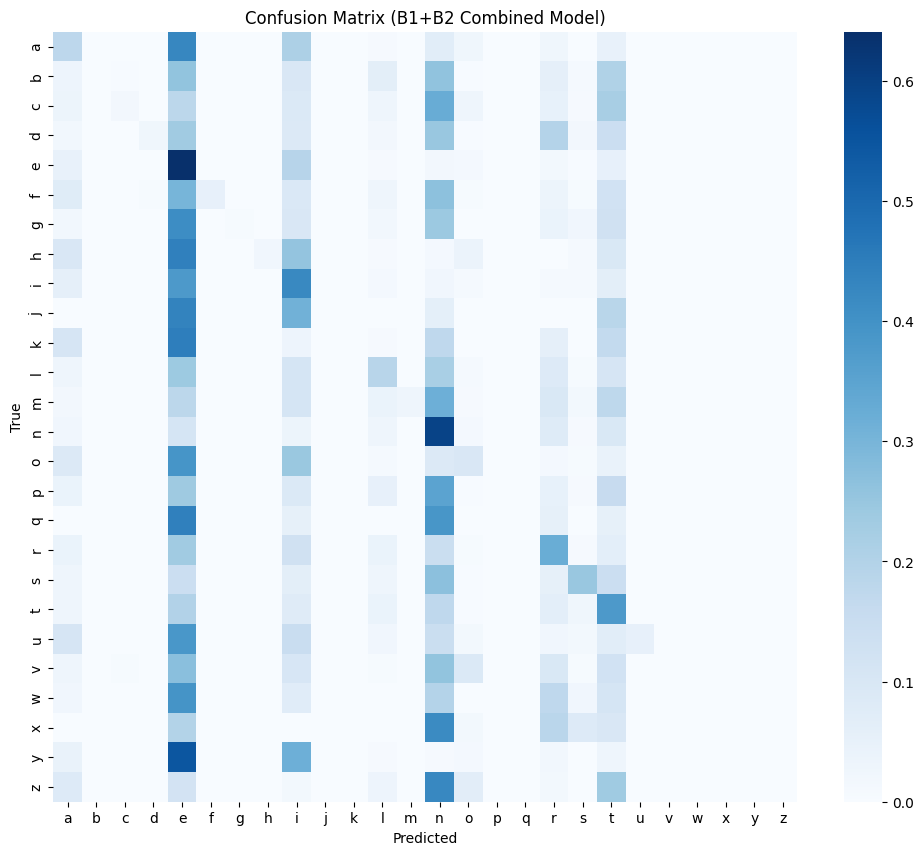


=== Per-Length Log-Likelihood Summary ===
Length  2:     2 words | Avg logP = -11.066
Length  3:     9 words | Avg logP = -11.089
Length  4:    37 words | Avg logP = -13.837
Length  5:    91 words | Avg logP = -15.783
Length  6:   138 words | Avg logP = -18.303
Length  7:   205 words | Avg logP = -20.993
Length  8:   246 words | Avg logP = -23.290
Length  9:   274 words | Avg logP = -25.599
Length 10:   282 words | Avg logP = -27.982
Length 11:   226 words | Avg logP = -30.139
Length 12:   164 words | Avg logP = -32.085
Length 13:   128 words | Avg logP = -34.083
Length 14:    86 words | Avg logP = -35.836
Length 15:    47 words | Avg logP = -38.941
Length 16:    33 words | Avg logP = -41.217
Length 17:    17 words | Avg logP = -43.077
Length 18:     8 words | Avg logP = -46.396
Length 19:     3 words | Avg logP = -48.871
Length 20:     2 words | Avg logP = -54.441
Length 21:     1 words | Avg logP = -60.604
Length 22:     1 words | Avg logP = -54.412


In [14]:
# ==========================================
# 🔹 Patched Evaluation using Candidate Filter + Trigram Interpolation
# ==========================================
from tqdm import tqdm
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

confusion = np.zeros((26, 26))
true_labels, pred_labels = [], []
log_likelihoods = []
top1_hits = 0
top3_hits = 0
true_prob_sum = 0.0
total_positions = 0

for w in tqdm(test_words, desc="Evaluating B1+B2"):
    hmm = get_interpolated_hmm(len(w), seqs_by_len)
    ll = score_word_log(w, hmm)
    log_likelihoods.append(ll)
    seq = ['^'] + list(w) + ['$']

    # Per-position next-letter probabilities
    for i in range(1, len(seq) - 1):
        a, b = seq[i - 1], seq[i]
        if a in string.ascii_lowercase and b in string.ascii_lowercase:
            # --- Candidate-filtered distribution ---
            probs = letter_probs_from_candidates('_' * len(w), hmm=hmm)

            # --- Interpolated trigram probability fusion ---
            trigram_probs = np.array([
                interpolated_prob(seq[i - 2] if i - 2 >= 0 else '^',
                                  a, ch,
                                  unigram, bigram, trigram)
                for ch in letters
            ])
            trigram_probs /= trigram_probs.sum() + 1e-12

            # Blend both (tunable weights)
            final_probs = 0.7 * probs + 0.3 * trigram_probs
            final_probs /= final_probs.sum() + 1e-12

            pred_idx = np.argmax(final_probs)
            pred_letter = letters[pred_idx]
            true_letter = b

            true_labels.append(true_letter)
            pred_labels.append(pred_letter)

            confusion[idx_letter[true_letter], idx_letter[pred_letter]] += 1

            total_positions += 1
            true_prob_sum += final_probs[idx_letter[true_letter]]
            if pred_letter == true_letter:
                top1_hits += 1
            if idx_letter[true_letter] in np.argsort(final_probs)[-3:]:
                top3_hits += 1

# ---------- Metrics ----------
avg_log_likelihood = np.mean(log_likelihoods)
perplexity = np.exp(-avg_log_likelihood / np.mean([len(w) + 2 for w in test_words]))
mean_true_prob = true_prob_sum / total_positions
top1_acc = top1_hits / total_positions
top3_acc = top3_hits / total_positions

print("\n=== HMM Evaluation Report (B1+B2) ===")
print(f"Total test words: {len(test_words):,}")
print(f"Average log-likelihood: {avg_log_likelihood:.4f}")
print(f"Perplexity: {perplexity:.4f}")
print(f"Mean prob(true next-letter): {mean_true_prob:.4f}")
print(f"Top-1 accuracy: {top1_acc*100:.2f}% | Top-3 accuracy: {top3_acc*100:.2f}%")

print("\n=== Per-Letter Classification Report ===")
print(classification_report(true_labels, pred_labels, digits=3))

# ---------- Confusion Matrix ----------
conf_norm = confusion / (confusion.sum(axis=1, keepdims=True) + 1e-9)
df_conf = pd.DataFrame(conf_norm, index=letters, columns=letters)
plt.figure(figsize=(12, 10))
sns.heatmap(df_conf, cmap="Blues", xticklabels=letters, yticklabels=letters)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (B1+B2 Combined Model)")
plt.show()

# ---------- Per-length Log-Likelihood Summary ----------
results_by_len = defaultdict(list)
for w, ll in zip(test_words, log_likelihoods):
    results_by_len[len(w)].append(ll)

print("\n=== Per-Length Log-Likelihood Summary ===")
for L, vals in sorted(results_by_len.items()):
    print(f"Length {L:2d}: {len(vals):5d} words | Avg logP = {np.mean(vals):.3f}")


In [15]:
print("\n=== HMM Evaluation Report ===")
print(f"Total test words: {len(test_words):,}")
print(f"Average log-likelihood: {avg_log_likelihood:.4f}")
print(f"Perplexity (lower = better): {perplexity:.4f}")
print(f"Letter prediction accuracy: {accuracy*100:.2f}%")

# Detailed classification report
try:
    from sklearn.metrics import classification_report
    print("\n=== Per-Letter Classification Report ===")
    print(classification_report(true_labels, pred_labels, digits=3, zero_division=0))
except Exception as e:
    print("sklearn not available or error when computing classification report:", e)

# Example: show most likely next letters after 't' from global model
try:
    t_idx = HMM_global["index"]['t']
    next_probs = HMM_global["A"][t_idx]
    top_next = sorted(zip(HMM_global["symbols"], next_probs), key=lambda x: x[1], reverse=True)[:10]
    print("\nMost likely after 't':", top_next)
except Exception as e:
    print("Could not compute transition example:", e)



=== HMM Evaluation Report ===
Total test words: 2,000
Average log-likelihood: -26.8581
Perplexity (lower = better): 10.0492


NameError: name 'accuracy' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Normalize confusion matrix by rows
conf_norm = confusion / (confusion.sum(axis=1, keepdims=True) + 1e-9)
df_conf = pd.DataFrame(conf_norm, index=letters, columns=letters)

plt.figure(figsize=(12,10))
sns.heatmap(df_conf, cmap="Blues", xticklabels=letters, yticklabels=letters)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Letter Prediction Confusion Matrix (Normalized, Patched HMM)")
plt.show()


In [ ]:
results_by_len = defaultdict(list)
for w, ll in zip(test_words, log_likelihoods):
    results_by_len[len(w)].append(ll)

print("\n=== Per-Length Log-Likelihood Summary ===")
for L, vals in sorted(results_by_len.items()):
    print(f"Length {L:2d}: {len(vals):5d} words | Avg logP = {np.mean(vals):.3f}")


In [ ]:
# run after loading HMM_global
letters = list(string.ascii_lowercase)
idx = HMM_global["index"]
A = HMM_global["A"]

predicted_set = set()
for a in letters:
    preds = np.argmax(A[idx[a], [idx[l] for l in letters]])
    predicted_set.add(letters[preds])
print("Distinct letters ever predicted (global argmax):", sorted(predicted_set))


In [ ]:
def topk_metrics(true_labels, pred_probs_matrix, k=3):
    # pred_probs_matrix rows aligned to true_labels positions, each row has 26 probs corresponding to letters
    topk_hits = 0
    for true, probs in zip(true_labels, pred_probs_matrix):
        topk = np.argsort(probs)[-k:]
        if idx_letter[true] in topk:
            topk_hits += 1
    return topk_hits / len(true_labels)

# You can construct pred_probs_matrix by using A[idx[a], letter_indices] in your evaluation loop.
